In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'png'
mpl.rcParams['figure.dpi']= 300

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 60)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sklearn
from sklearn.preprocessing import StandardScaler, Binarizer, LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate \
                                    ,cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.metrics import roc_curve, auc

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


# Helper Functions

In [4]:
target_names=['No','Yes']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def confusion_matrices(y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names,
                          title='Confusion matrix, without normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                          title='Confusion matrix, Normalized')

In [5]:
def plot_roc_curve(fit_model, title):
    y_score=fit_model.predict_proba(X_test)[:,1]
    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    # Plotting the Baseline
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr)
    plt.grid(which='major')
    plt.title(f"{title} ROC curve")
    s= 'AUC: ' + str(round(metrics.roc_auc_score(y_test, fit_model.predict(X_test)),3))
    plt.text(0.75, 0.25, s=s, ha='right', va='bottom', fontsize=14,
             bbox=dict(facecolor='grey', alpha=0.5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate');

# Load Data

In [6]:
cupid = pd.read_hdf('data/cupid_cleaned.hd5', key='df', mode='r')
#cupid = load_pd_pkl('data/cupid_cleaned')

# Create binary "wants_kids" YES vs NO from the more options
cupid['wants_kids_binary'] = ['yes' if x == 'yes' else 'no' if x == 'no' else np.nan for x in cupid['wants_kids']]
cupid['status_available'] =  ['yes' if x == 'available' else 'yes' if x == 'single' else np.nan for x in cupid['status']]


target = ['wants_kids_binary']
continuous = ['age'] #, 'height']
# bi_categorical = ['sex', 'signs_fun', 'signs_unimportant', 'signs_important',
#                      'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                      'religion_serious', ]
# mult_categorical = ['body_type', 'drinks', 'drugs', 'income', 'orientation', 'status',
#                       'diet_intensity', 'diet_choice', 'primary_ethnicity',
#                       'has_kids','likes_cats', 'likes_dogs', 'dislikes_cats', 'dislikes_dogs',
#                       'has_cats', 'has_dogs','english_fluent','english_poor','spanish_fluent',
#                       'spanish_not_poorly','religion_name','new_education',]



# remove from bi: 'signs_fun', 'signs_unimportant', 'signs_important', 'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                     'religion_serious',

bi_categorical = ['sex', 'signs_fun', 'signs_unimportant', 'signs_important', 
                  'religion_unserious', 'religion_laughing', 'religion_somewhat', 'religion_serious']


# remove from multi:  'new_education','likes_cats', 'likes_dogs', 'dislikes_cats', 
#          'dislikes_dogs', 'has_cats', 'has_dogs', 'primary_ethnicity', , 
#          'english_fluent','english_poor','spanish_fluent','spanish_not_poorly',
#          'diet_intensity', 'diet_choice', 'religion_name'
                      
mult_categorical = ['orientation', 'status_available',
                      'drinks', 'smokes', 'drugs', 'religion_name',]


# Assign feature groupings
columns = bi_categorical + mult_categorical + target

# Create DF of everything
df = cupid[target + continuous + bi_categorical + mult_categorical]

### Change data type of age
df['age'] = df.age.astype(float)

df = df.dropna()

# Split DF of only standardized/scaled features
scaled_features = df.copy().loc[:, continuous]

# Tranform age and height (standardized features)
features = scaled_features[continuous]
features = StandardScaler().fit_transform(features.values)
scaled_features[continuous] = features

# Create dummy variables for original features, then combine back with scaled features
dummies = pd.get_dummies(df.loc[:, columns], columns=columns, drop_first=False)
df = scaled_features.join(dummies)

# Drop all "placeholder" columns
df.drop(df.filter(regex='placeholder'), axis=1, inplace=True)

# Drop extra one-hot columns. Only available and single people now in dataset.
df.drop(columns=['status_available_yes', 'wants_kids_binary_no', 'sex_f','signs_important_matters a lot',
                 'religion_serious_very serious','orientation_straight','drinks_very often','smokes_yes',
                 'drugs_often','religion_name_other'], axis=1, inplace=True)


# SETUP MODELING DATA

X = df.drop('wants_kids_binary_yes', axis=1)
y = df['wants_kids_binary_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

# print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
# print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

# print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

cupid2 = pd.read_hdf('data/cupid_cleaned.hd5', key='df', mode='r')
#cupid = load_pd_pkl('data/cupid_cleaned')

# Create binary "wants_kids" YES vs NO from the more options
cupid2['wants_kids_binary'] = ['yes' if x == 'yes' else 'no' if x == 'no' else np.nan for x in cupid2['wants_kids']]
cupid2['has_kids_options'] = ['one' if x == 'one' else 'multiple' if x == 'multiple' else 'no' if x == 'no' else np.nan for x in cupid2['has_kids']]

cupid2['status_available'] =  ['yes' if x == 'available' else 'yes' if x == 'single' else np.nan for x in cupid2['status']]

target = ['wants_kids_binary']
continuous = ['age'] #, 'height']
# bi_categorical = ['sex', 'signs_fun', 'signs_unimportant', 'signs_important',
#                      'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                      'religion_serious', ]
# mult_categorical = ['body_type', 'drinks', 'drugs', 'income', 'orientation', 'status',
#                       'diet_intensity', 'diet_choice', 'primary_ethnicity',
#                       'has_kids','likes_cats', 'likes_dogs', 'dislikes_cats', 'dislikes_dogs',
#                       'has_cats', 'has_dogs','english_fluent','english_poor','spanish_fluent',
#                       'spanish_not_poorly','religion_name','new_education',]



# remove from bi: 'signs_fun', 'signs_unimportant', 'signs_important', 'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                     'religion_serious',

bi_categorical = ['sex', 'signs_fun', 'signs_unimportant', 'signs_important', 
                  'religion_unserious', 'religion_laughing', 'religion_somewhat', 'religion_serious']


# remove from multi:  'new_education','likes_cats', 'likes_dogs', 'dislikes_cats', 
#          'dislikes_dogs', 'has_cats', 'has_dogs', 'primary_ethnicity', , 
#          'english_fluent','english_poor','spanish_fluent','spanish_not_poorly',
#          'diet_intensity', 'diet_choice', 'religion_name'
                      
mult_categorical = ['orientation', 'status_available', 'has_kids_options',
                      'drinks', 'smokes', 'drugs', 'religion_name',]


# Assign feature groupings
columns2 = bi_categorical + mult_categorical + target

# Create DF of everything
df2 = cupid2[target + continuous + bi_categorical + mult_categorical]

### Change data type of age
df2['age'] = df2.age.astype(float)

df2 = df2.dropna()

# Split DF of only standardized/scaled features
scaled_features = df2.copy().loc[:, continuous]

# Tranform age and height (standardized features)
features = scaled_features[continuous]
features = StandardScaler().fit_transform(features.values)
scaled_features[continuous] = features

# Create dummy variables for original features, then combine back with scaled features
dummies = pd.get_dummies(df2.loc[:, columns2], columns=columns2, drop_first=False)
df2 = scaled_features.join(dummies)

# Drop all "placeholder" columns
df2.drop(df2.filter(regex='placeholder'), axis=1, inplace=True)


# Drop unused binary column
df2.drop('has_kids_options_no', axis=1, inplace=True)
df2.drop(columns=['status_available_yes', 'wants_kids_binary_no', 'sex_f','signs_important_matters a lot',
                 'religion_serious_very serious','orientation_straight','drinks_very often','smokes_yes',
                 'drugs_often','religion_name_other'], axis=1, inplace=True)


# SETUP MODELING DATA

X2 = df2.drop('wants_kids_binary_yes', axis=1)
y2 = df2['wants_kids_binary_yes']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42, stratify=y2)

# print("Before OverSampling, counts of label '1': {}".format(sum(y_train2==1)))
# print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train2==0)))

sm2 = SMOTE(random_state=42)
X_train2, y_train2 = sm2.fit_sample(X_train2, y_train2.ravel())

# print('After OverSampling, the shape of train_X: {}'.format(X_train2.shape))
# print('After OverSampling, the shape of train_y: {} \n'.format(y_train2.shape))

# print("After OverSampling, counts of label '1': {}".format(sum(y_train2==1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train2==0)))

/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
loaddir = 'models'

In [8]:
best_dt = joblib.load(f'{loaddir}/DecisionTree.joblib')
best_knn = joblib.load(f'{loaddir}/knn.joblib')
best_lr = joblib.load(f'{loaddir}/logreg.joblib')
best_nb = joblib.load(f'{loaddir}/NaiveBayesGaussian.joblib')
best_rf = joblib.load(f'{loaddir}/RandomForest.joblib')
best_svm = joblib.load(f'{loaddir}/SVM.joblib')

In [9]:
best_svm_knowing_children = joblib.load(f'{loaddir}/SVM_knowing_current_children.joblib')
best_gb_blind = joblib.load(f'{loaddir}/GradientBoosting_reducedfeatures.joblib')

In [10]:
savedir = 'plots'

In [12]:
def plot_roc_curve_mult(best_gb_blind, best_dt, best_knn, best_lr, best_nb, best_rf, best_svm):
    y_score_gb = best_gb_blind.predict_proba(X_test)[:,1]
    y_score_dt = best_dt.predict_proba(X_test)[:,1]
    y_score_knn = best_knn.predict_proba(X_test)[:,1]
    y_score_lr = best_lr.predict_proba(X_test)[:,1]
    y_score_nb = best_nb.predict_proba(X_test)[:,1]
    y_score_rf = best_rf.predict_proba(X_test)[:,1]
    y_score_svm = best_svm.predict_proba(X_test)[:,1]

    
    hfont = {'fontname':'Carlito',
             'size': 12}
    
    titlefont = {'fontname':'Carlito',
             'size': 16}
    
    fpr1, tpr1, _ = roc_curve(y_test, y_score_gb)
    fpr2, tpr2, _ = roc_curve(y_test, y_score_dt)
    fpr3, tpr3, _ = roc_curve(y_test, y_score_knn)
    fpr4, tpr4, _ = roc_curve(y_test, y_score_lr)
    fpr5, tpr5, _ = roc_curve(y_test, y_score_nb)
    fpr6, tpr6, _ = roc_curve(y_test, y_score_rf)
    fpr7, tpr7, _ = roc_curve(y_test, y_score_svm)
    
    plt.clf()
    plt.figure(figsize = (8,8), dpi=300)
    plt.xlim(xmin=0, xmax=1)
    plt.ylim(ymin=0, ymax=1.001)
#     plt.f
#     plt.figtext(.55, .35,"SVM AUC = .774",bbox=dict(facecolor='#FA3B66', alpha=0.5), **titlefont)
#     plt.figtext(.55, .30,"GB  AUC  =  .806",bbox=dict(facecolor='#2274a5', alpha=0.5), **titlefont)

    #Plot the baseline
    plt.plot([0,1],[0,1], c='#ccced2', ls='--')
    plt.plot(fpr1, tpr1, label='GB') #, c='#FA3B66', linewidth=2)
    plt.plot(fpr2, tpr2, label='DT') #, c='#2274a5', linewidth=2)
    plt.plot(fpr3, tpr3, label='KNN')
    plt.plot(fpr4, tpr4, label='LR')    
    plt.plot(fpr5, tpr5, label='NB')
    plt.plot(fpr6, tpr6, label='RF')    
    plt.plot(fpr7, tpr7, label='SVM')    
    plt.title('ROC Curve', **titlefont)
    plt.xlabel('False Positive Rate', horizontalalignment='left', x=0, **hfont)
    plt.ylabel('True Positive Rate', verticalalignment='top', y=1.045, rotation=0, labelpad = -45, **hfont)
    plt.xticks(list(np.linspace(.1,1,10)))
    plt.yticks(list(np.linspace(.1,1,10)))
    plt.grid(b=True, which='major', axis='both', alpha=0.2)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
    plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])
    plt.legend(labels=['Y=X', 'GB', 'DT', 'KNN', 'LR', 'NB', 'RF', 'SVM'], loc='lower right')
    return plt

fig = plot_roc_curve_mult(best_gb_blind, best_dt, best_knn, best_lr, best_nb, best_rf, best_svm)

# fig.savefig(f'./{savedir}/all_ROC_AUCs.png', format='png', dpi=300, bbox_inches='tight', transparent=True)

ValueError: X.shape[1] = 28 should be equal to 38, the number of features at training time

In [ ]:
def plot_roc_curve_single2(secondary_model):
#     y_score_main = main_model.predict_proba(X_test)[:,1]
    y_score_second = secondary_model.predict_proba(X_test2)[:,1]
    
    
    hfont = {'fontname':'Carlito',
             'size': 16}
    
    tickfont = {'fontname':'Carlito',
             'size': 16}
    
    titlefont = {'fontname':'Carlito',
             'size': 28}
    
#     fpr1, tpr1, _ = roc_curve(y_test, y_score_main)
    fpr2, tpr2, _ = roc_curve(y_test2, y_score_second)
    plt.clf()
    plt.figure(figsize = (8,8), dpi=300, frameon=False)
    plt.xlim(xmin=0, xmax=1)
    plt.ylim(ymin=0, ymax=1.001)
#     plt.figtext(.55, .35,"SVM AUC = .774",bbox=dict(facecolor='#FA3B66', alpha=0.5), **titlefont)
    plt.figtext(.55, .27,"SVM AUC = .806",bbox=dict(facecolor='#2274a5', alpha=0.7), **titlefont)

    #Plot the baseline
#     plt.plot([0,1],[0,1], c='#ccced2', ls='--')
#     plt.plot(fpr1, tpr1, c='#FA3B66', linewidth=2)
    plt.plot(fpr2, tpr2, c='#2274a5', linewidth=2.5, alpha =0.8)
#     plt.title('ROC Curve', **titlefont)
#     plt.xlabel('False Positive Rate', horizontalalignment='left', x=0, **hfont)
#     plt.ylabel('True Positive Rate', verticalalignment='top', y=1.045, rotation=0, labelpad = -45, **hfont)
    plt.xticks([])
    plt.yticks([])
#     plt.axis(spines['right'].set_visible(False))
#     plt.spines['top'].set_visible(False)
#     plt.grid(b=True, which='major', axis='both', alpha=0.2)
#     plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
#     plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])
    sns.despine(ax=plt.gca())
    return plt

fig = plot_roc_curve_single2(best_svm_knowing_children)

# fig.savefig(f'./{savedir}/best_svm_ROC_plot.png', format='png', dpi=300, bbox_inches='tight', Frameon=True, transparent=True)

In [ ]:
def plot_roc_curve_single(main_model):
    y_score_main = main_model.predict_proba(X_test)[:,1]
#     y_score_second = secondary_model.predict_proba(X_test2)[:,1]
    
    
    hfont = {'fontname':'Carlito',
             'size': 16}
    
    tickfont = {'fontname':'Carlito',
             'size': 16}
    
    titlefont = {'fontname':'Carlito',
             'size': 28}
    
    fpr1, tpr1, _ = roc_curve(y_test, y_score_main)
#     fpr2, tpr2, _ = roc_curve(y_test2, y_score_second)
    plt.clf()
    plt.figure(figsize = (8,8), dpi=300)
    plt.xlim(xmin=0, xmax=1)
    plt.ylim(ymin=0, ymax=1.001)
#     plt.f
#     plt.figlegend(
    plt.figtext(.55, .35,'GB  AUC  =  .774',bbox=dict(facecolor='#FA3B66', alpha=0.8), **titlefont)
#     plt.figtext(.55, .30,"GB  AUC  =  .806",bbox=dict(facecolor='#2274a5', alpha=0.5), **titlefont)

    #Plot the baseline
    plt.plot([0,1],[0,1], c='#ccced2', ls='--')
    plt.plot(fpr1, tpr1, c='#FA3B66', linewidth=2.5, alpha = 0.8)
#     plt.plot(fpr2, tpr2, c='#2274a5', linewidth=2)
    plt.title('ROC Curve', **titlefont)
    plt.xlabel('False Positive Rate', horizontalalignment='left', x=0, **hfont)
    plt.ylabel('True Positive Rate', verticalalignment='top', y=1.045, rotation=0, labelpad = -59, **hfont)
    plt.xticks(list(np.linspace(.1,1,10)), **tickfont)
    plt.yticks(list(np.linspace(.1,1,10)), **tickfont)
    plt.grid(b=True, which='major', axis='both', alpha=0.2)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
    plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])
    sns.despine(ax=plt.gca())
    return plt

fig = plot_roc_curve_single(best_gb_blind)

# fig.savefig(f'./{savedir}/best_gb_ROC_plot.png', format='png', dpi=300, bbox_inches='tight', Frameon=True, transparent=True)

In [ ]:
model_names = ['Gradient\nBoosting', 'SVM', 'Random\nForest', 'Log\nRegression', 'KNN', 'Decision\nTree', 'Naive\nBayes']
auc_scores = [.774, .765, .762, .759, .758,  .727,  .727]

yfont = {'fontname':'Carlito',
             'size': 21}

xfont = {'fontname':'Carlito',
             'size': 19}
    
titlefont = {'fontname':'Carlito',
             'size': 33}

plt.clf()
plt.figure(figsize= (10.2,10), dpi = 300)

plt.title('AUC Score Comparison', **titlefont)

# plt.xticks([])
plt.yticks(np.linspace(0.1, 0.8, 8), **yfont)
plt.xticks(**xfont)
plt.ylabel('', labelpad = -100)

plt.hlines(list(np.linspace(0.1, 0.7, 7)),xmin=-0.5, xmax=12, colors='w', linestyles='dotted', alpha=0.5)

plt.bar(model_names, auc_scores, align='center', color=['#FA3B66', '#ccced2', '#ccced2', '#ccced2', '#ccced2', '#ccced2', '#ccced2'], alpha=.8)
sns.despine(ax=plt.gca(), left=True, bottom=True)

# plt.savefig(f'./{savedir}/AUC_score_comparison.png', format='png', dpi=300, bbox_inches='tight', Frameon=True, transparent=True)

In [ ]:
def plot_roc_curve_single(main_model):
    y_score_main = main_model.predict_proba(X_test)[:,1]
#     y_score_second = secondary_model.predict_proba(X_test2)[:,1]
    
    
    hfont = {'fontname':'Carlito',
             'size': 16}
    
    tickfont = {'fontname':'Carlito',
             'size': 16}
    
    titlefont = {'fontname':'Carlito',
             'size': 28}
    
    fpr1, tpr1, _ = roc_curve(y_test, y_score_main)
#     fpr2, tpr2, _ = roc_curve(y_test2, y_score_second)
    plt.clf()
    plt.figure(figsize = (8,8), dpi=300)
    plt.xlim(xmin=0, xmax=1)
    plt.ylim(ymin=0, ymax=1.001)
    plt.legend()
#     plt.figtext(.55, .35,'GB  AUC  =  .774',bbox=dict(facecolor='#FA3B66', alpha=0.8), **titlefont)

    #Plot the baseline
    plt.plot([0,1],[0,1], c='#ccced2', ls='--')
    plt.plot(fpr1, tpr1, c='#FA3B66', linewidth=2.5, alpha = 0.8)
#     plt.plot(fpr2, tpr2, c='#2274a5', linewidth=2)
    plt.title('ROC Curve', **titlefont)
    plt.xlabel('False Positive Rate', horizontalalignment='left', x=0, **hfont)
    plt.ylabel('True Positive Rate', verticalalignment='top', y=1.045, rotation=0, labelpad = -59, **hfont)
    plt.xticks(list(np.linspace(.1,1,10)), **tickfont)
    plt.yticks(list(np.linspace(.1,1,10)), **tickfont)
    plt.grid(b=True, which='major', axis='both', alpha=0.2)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
    plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])
    sns.despine(ax=plt.gca())
    return plt

fig = plot_roc_curve_single(best_gb_blind)

# fig.savefig(f'./{savedir}/best_gb_ROC_plot.png', format='png', dpi=300, bbox_inches='tight', Frameon=True, transparent=True)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

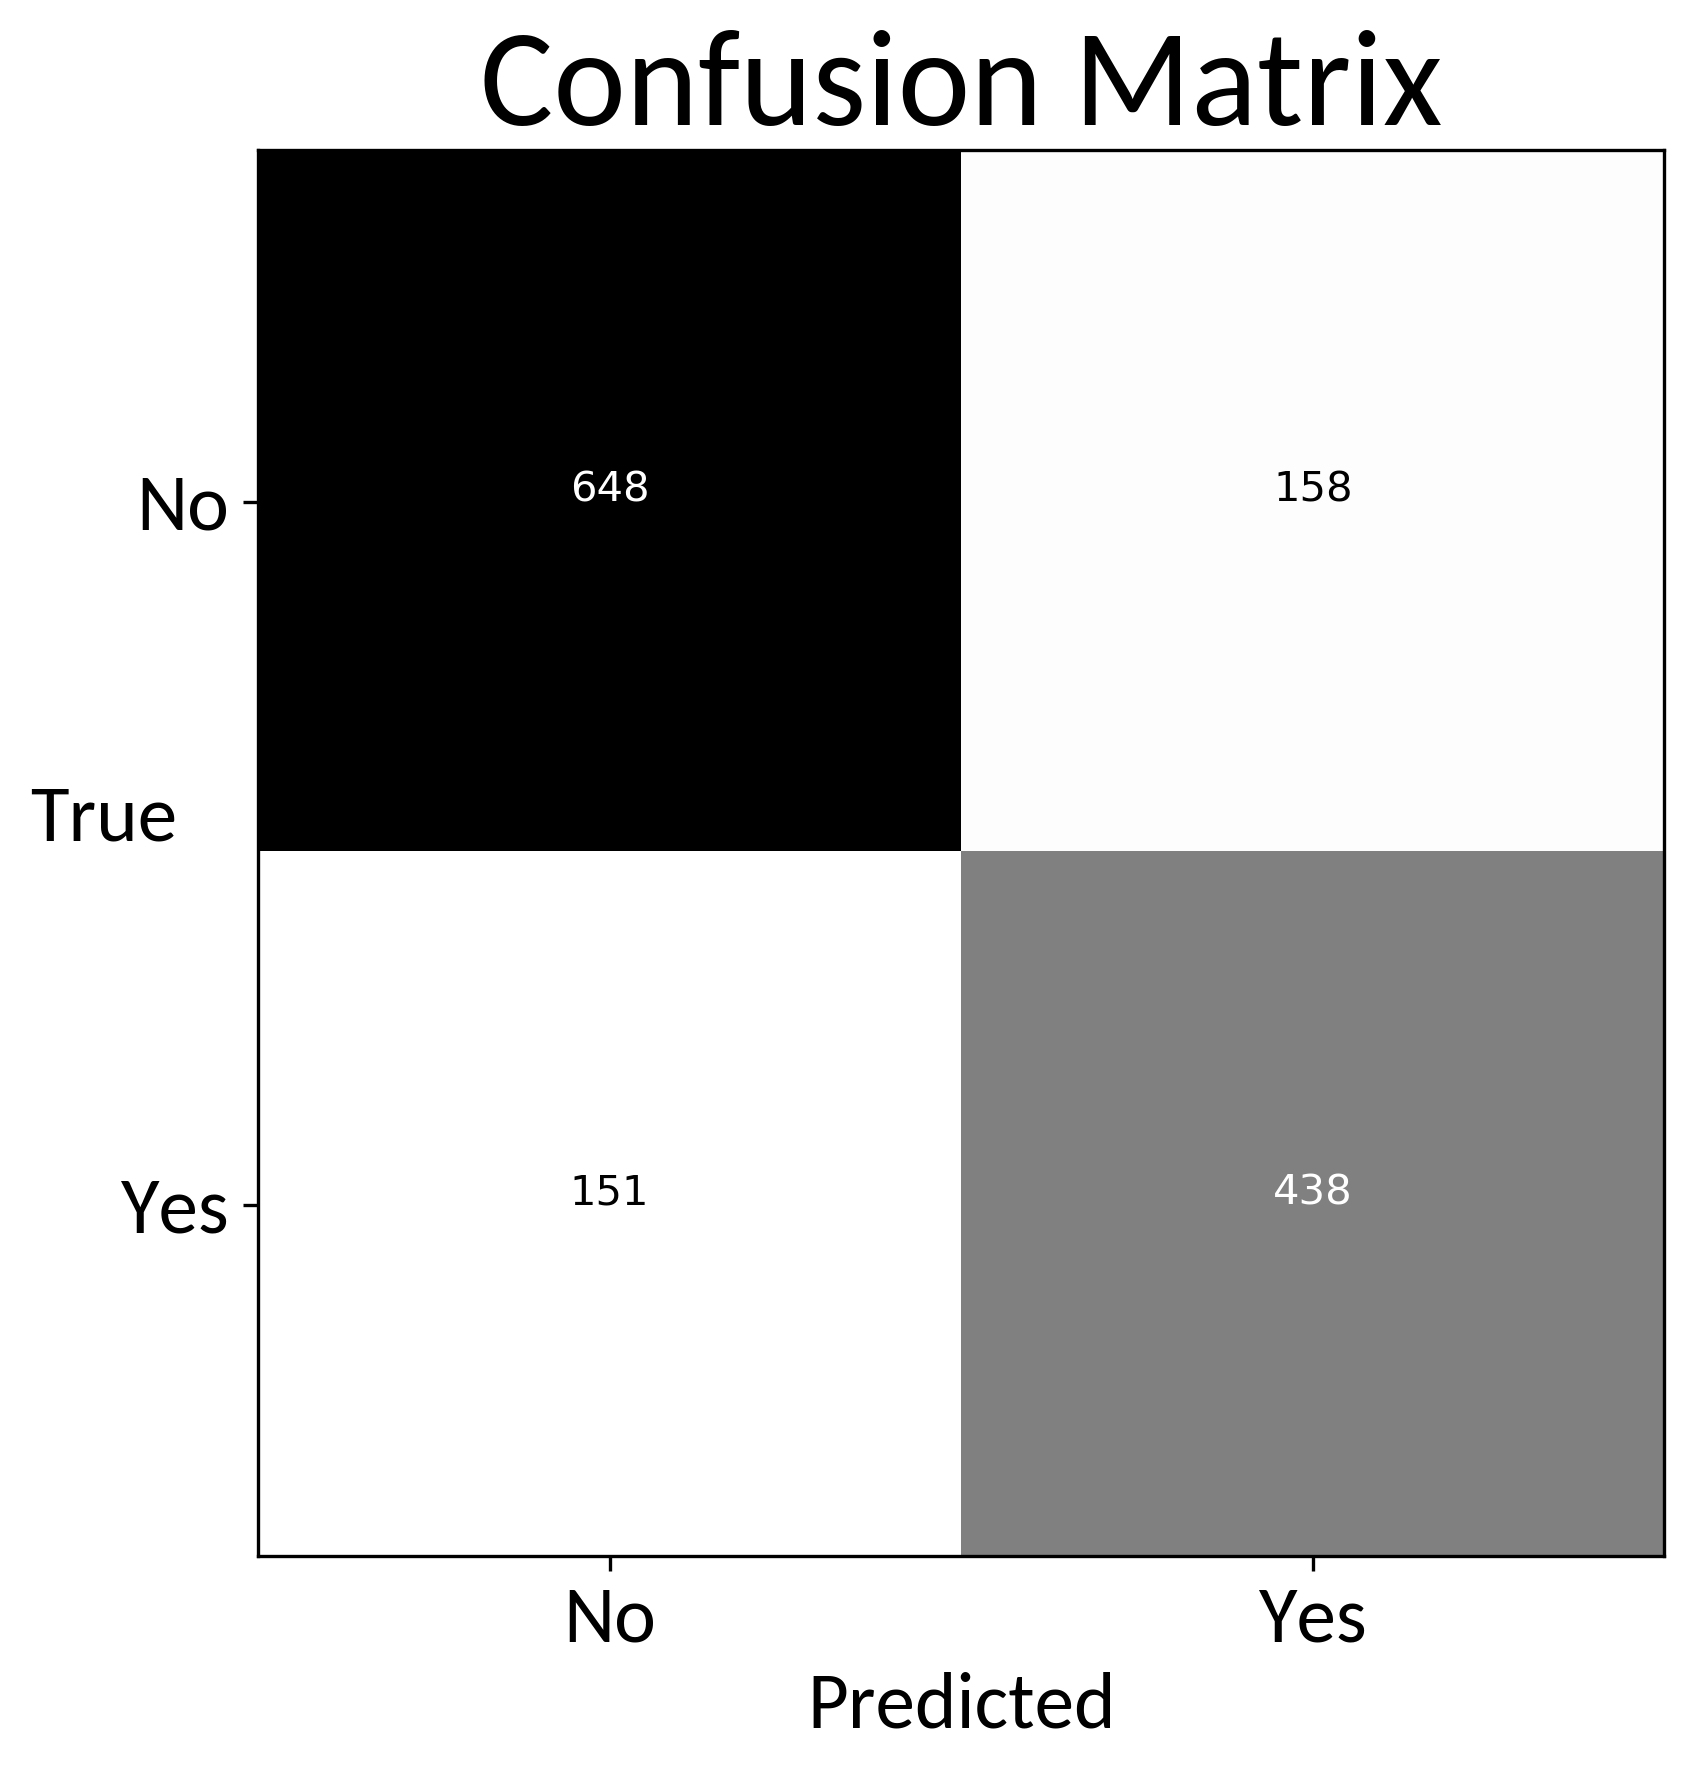

In [18]:
target_names=['No','Yes']


yfont = {'fontname':'Carlito',
             'size': 21}

xfont = {'fontname':'Carlito',
             'size': 19}
    
titlefont = {'fontname':'Carlito',
             'size': 33}


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix of Holdout Set',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
                          
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#         print('Confusion matrix of holdout')

#     print(cm)
    plt.figure(figsize= (6,6), dpi = 300)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, **titlefont)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, **xfont)
    plt.yticks(tick_marks, classes, **xfont)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True', rotation=0, **xfont)
    plt.xlabel('Predicted', **xfont)
    plt.tight_layout()
    return plt

def confusion_matrices(y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
#     np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names,
                          title='Confusion Matrix')
    return plt
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                          title='Normalized Confusion Matrix')

plt.clf()
fig = confusion_matrices(best_gb_blind.predict(X_test))
# fig.savefig(f'./{savedir}/ConfusionMatrixCount.png', format='png', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
target_names=['No','Yes']


yfont = {'fontname':'Carlito',
             'size': 21}

xfont = {'fontname':'Carlito',
             'size': 19}
    
titlefont = {'fontname':'Carlito',
             'size': 33}


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix of Holdout Set',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#         print('Confusion matrix of holdout')

#     print(cm)
    plt.figure(figsize= (6,6), dpi = 300)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, **titlefont)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, **xfont)
    plt.yticks(tick_marks, classes, **xfont)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True', rotation=0, **xfont)
    plt.xlabel('Predicted', **xfont)
    plt.tight_layout()
    return plt

def confusion_matrices(y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
#     np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
#     plt.figure()
#     plot_confusion_matrix(cnf_matrix, classes=target_names,
#                           title='Confusion Matrix')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                          title='Normalized Confusion Matrix')
    return plt


plt.clf()
fig = confusion_matrices(best_gb_blind.predict(X_test))
# fig.savefig(f'./{savedir}/ConfusionMatrixNormalized.png', format='png', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
# fig, ax = plt.subplots(figsize=(8,6))
# sns.heatmap(df.corr(), xticklabels=True, cmap='BrBG');

# def plot_corr():
    
hfont = {'fontname':'Carlito',
         'size': 16}

tickfont = {'fontname':'Carlito',
         'size': 16}

titlefont = {'fontname':'Carlito',
         'size': 28}
    
#     plt.figure(figsize = (8,8), dpi=300)
# #     fig, ax = plt.subplots(figsize=(8,6), dpi=300)
#     sns.heatmap(df.corr(), xticklabels=True, cmap='BrBG');
# #     plt.xlim(xmin=0, xmax=1)
# #     plt.ylim(ymin=0, ymax=1.001)
    
#     plt.colorbar()
#     plt.title('Feature Correlation Heatmap', **titlefont)
# #     plt.xlabel('False Positive Rate', horizontalalignment='left', x=0, **hfont)
# #     plt.ylabel('True Positive Rate', verticalalignment='top', y=1.045, rotation=0, labelpad = -59, **hfont)
# #     plt.xticks(list(np.linspace(.1,1,10)), **tickfont)
# #     plt.yticks(list(np.linspace(.1,1,10)), **tickfont)
# #     plt.grid(b=True, which='major', axis='both', alpha=0.2)
# #     plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
# #     plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])
#     sns.despine(ax=plt.gca())
#     return ax

# fig = plot_corr()
fig, ax = plt.subplots(figsize=(8,6), dpi=300)
sns_heat = sns.heatmap(df.corr(), xticklabels=True, cmap='BrBG')
ax.set_title('Feature Correlation Heatmap', **titlefont)
ax.set_xticklabels(df.columns,rotation=87)
fig = sns_heat.get_figure()
# sns_heat.title('Feature Correlation Heatmap', **titlefont)
# fig.savefig(f'./{savedir}/CorrelationHeatmap.png', format='png', dpi=300, bbox_inches='tight', transparent=True, **titlefont)